In [1]:
# =============================================================================
# SETUP AND IMPORTS
# =============================================================================
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging
import sys
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Project paths
repo_root = Path.cwd().parent
src_path = repo_root / "src"
scripts_path = repo_root / "scripts"
data_path = repo_root / "data"
results_path = repo_root / "results"

# Add paths
sys.path.insert(0, str(src_path))
sys.path.insert(1, str(scripts_path))
from add_generators import add_all_generators
# Check Gurobi availability
try:
    import gurobipy as gp
    GUROBI_AVAILABLE = True
    print(f"✓ Gurobi version: {gp.gurobi.version()}")
except ImportError:
    GUROBI_AVAILABLE = False
    print("⚠ Gurobi not available - will fall back to HiGHS or other solver")

print(f"\nPyPSA version: {pypsa.__version__}")
print(f"Project root: {repo_root}")

✓ Gurobi version: (13, 0, 0)

PyPSA version: 1.0.5
Project root: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model


## 1. Load Network

Load the network we built in network_05.ipynb or create a fresh one.

In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Network configuration
N_CLUSTERS = 200
STRATEGY = 'kmeans'
START_DATE = '2023-01-01'
END_DATE = '2023-01-07'  # One week for faster optimization

# Solver configuration
SOLVER_NAME = 'gurobi' if GUROBI_AVAILABLE else 'highs'

# Gurobi solver options (following PyPSA-EUR)
GUROBI_OPTIONS = {
    'MIPGap': 0.01,            # 1% optimality gap
    'TimeLimit': 7200,         # 2 hour time limit
    'Threads': 10,             # Number of threads
    'Method': 2,               # Barrier method (2) for LP
    'Crossover': 0,            # No crossover (faster)
    'BarHomogeneous': 1,       # Homogeneous algorithm
    'OutputFlag': 1,           # Show solver output
}

# HiGHS fallback options
HIGHS_OPTIONS = {
    'threads': 4,
    'time_limit': 7200,
}

SOLVER_OPTIONS = GUROBI_OPTIONS if SOLVER_NAME == 'gurobi' else HIGHS_OPTIONS

print(f"Solver: {SOLVER_NAME}")
print(f"Period: {START_DATE} to {END_DATE}")

Solver: gurobi
Period: 2023-01-01 to 2023-01-07


In [21]:
# =============================================================================
# LOAD OR BUILD NETWORK
# =============================================================================

# Try to load pre-built network from network_05
network_file = data_path / "networks" / "optimize" / f"network_{N_CLUSTERS}_complete.nc"

if network_file.exists():
    print(f"Loading network from {network_file}...")
    n = pypsa.Network(str(network_file))
else:
    print("Building network from scratch...")
    
    network = "O+_sEEN_2023-01-01.nc"
    
    # Load clustered network base
    cluster_path = data_path / "networks" / "optimize" / network
    
    if cluster_path.exists():
        n = pypsa.Network(str(cluster_path))
    else:
        raise FileNotFoundError(f"Network not found. Please run network_04.ipynb first.")
    
    # Set snapshots
    snapshots = pd.date_range(START_DATE, END_DATE, freq='h')
    n.set_snapshots(snapshots)
    
    # Add generators using our module
    n = add_all_generators(n, project_root=repo_root, aggregate_renewables=True)

print(f"\nNetwork summary:")
print(f"  Buses: {len(n.buses)}")
print(f"  Lines: {len(n.lines)}")
print(f"  Generators: {len(n.generators)}")
print(f"  Loads: {len(n.loads)}")
print(f"  Snapshots: {len(n.snapshots)}")

INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, lines, links, loads, sub_networks
INFO:add_generators:============================================================
INFO:add_generators:ADDING GENERATORS TO NETWORK
INFO:add_generators:============================================================
INFO:add_generators:Network countries: ['AT', 'BE', 'BG', 'CH', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']
INFO:add_generators:
[1/5] Loading power plant data...
INFO:add_generators:  Loaded 29565 power plants (1369.4 GW)
INFO:pypsa_simplified.network:Preparing 29565 generators...
INFO:pypsa_simplified.network:Filtered to 28881 generators in 28 countries


Building network from scratch...


INFO:pypsa_simplified.network:Mapping 28868 generators to 200 buses...
INFO:pypsa_simplified.network:Assigned 28868/28868 generators to buses
INFO:pypsa_simplified.network:Prepared 28868 generators for network addition
INFO:add_generators:
[2/5] Separating generator types...
INFO:add_generators:  Wind:            9498 (286.9 GW)
INFO:add_generators:  Solar:          11578 (132.0 GW)
INFO:add_generators:  Conventional:    7792 (865.9 GW)
INFO:add_generators:
[3/5] Creating renewable profiles from weather data...
INFO:add_generators:  Loaded 288 NUTS-2 regions
INFO:add_generators:  Loaded weather data: 87649 timesteps
INFO:add_generators:  Wind speed columns: 350
INFO:add_generators:  Radiation columns: 350
INFO:renewable_profiles:Assigning 9498 generators to NUTS-2 regions...
INFO:renewable_profiles:Assigned 9498/9498 generators to NUTS-2 regions
INFO:renewable_profiles:Assigning 11578 generators to NUTS-2 regions...
INFO:renewable_profiles:Assigned 11578/11578 generators to NUTS-2 regi


Network summary:
  Buses: 200
  Lines: 237
  Generators: 8156
  Loads: 6258
  Snapshots: 145


## 2. Network Validation Before Optimization

Critical checks before running the optimizer.

In [22]:
# =============================================================================
# VALIDATE NETWORK
# =============================================================================

def validate_network_for_optimization(n, verbose=True):
    """Check network is ready for optimization."""
    issues = []
    
    # Check basics
    if len(n.buses) == 0:
        issues.append("❌ No buses")
    if len(n.generators) == 0:
        issues.append("❌ No generators")
    if len(n.loads) == 0:
        issues.append("❌ No loads")
    if len(n.snapshots) == 0:
        issues.append("❌ No snapshots")
    
    # Check capacity adequacy
    total_capacity = n.generators['p_nom'].sum() / 1000  # GW
    
    if len(n.loads_t.p_set.columns) > 0:
        peak_demand = n.loads_t.p_set.sum(axis=1).max() / 1000  # GW
    else:
        peak_demand = n.loads['p_set'].sum() / 1000
    
    margin = (total_capacity / peak_demand - 1) * 100 if peak_demand > 0 else 0
    
    if margin < 10:
        issues.append(f"⚠ Low capacity margin: {margin:.1f}%")
    
    # Check line capacities
    if (n.lines['s_nom'] <= 0).any():
        issues.append("⚠ Some lines have zero/negative capacity")
    
    # Check generator constraints
    if (n.generators['p_nom'] < 0).any():
        issues.append("❌ Negative generator capacities")
    
    # NEW: Check for isolated buses with loads but no generators
    # This is the root cause of "Empty LHS with non-zero RHS" error
    buses_with_loads = set(n.loads['bus'].unique())
    buses_with_gens = set(n.generators['bus'].unique())
    buses_in_lines = set(n.lines['bus0'].unique()) | set(n.lines['bus1'].unique())
    buses_in_links = set(n.links['bus0'].unique()) | set(n.links['bus1'].unique())
    connected_buses = buses_in_lines | buses_in_links
    
    # Find buses with loads but no generators AND not connected
    isolated_buses = set(n.buses.index) - connected_buses
    problematic_buses = isolated_buses & buses_with_loads - buses_with_gens
    
    if problematic_buses:
        issues.append(f"❌ {len(problematic_buses)} isolated bus(es) with loads but NO generators: {list(problematic_buses)[:5]}")
    
    # Report
    if verbose:
        print("="*60)
        print("NETWORK VALIDATION")
        print("="*60)
        print(f"\nCapacity: {total_capacity:.1f} GW")
        print(f"Peak demand: {peak_demand:.1f} GW")
        print(f"Margin: {margin:.1f}%")
        print(f"\nNetwork topology:")
        print(f"  Total buses: {len(n.buses)}")
        print(f"  Buses with loads: {len(buses_with_loads)}")
        print(f"  Buses with generators: {len(buses_with_gens)}")
        print(f"  Connected buses (lines/links): {len(connected_buses)}")
        print(f"  Isolated buses: {len(isolated_buses)}")
        
        if issues:
            print(f"\n⚠ Issues found:")
            for issue in issues:
                print(f"  {issue}")
        else:
            print("\n✓ Network ready for optimization")
    
    return len(issues) == 0, problematic_buses

is_valid, problematic_buses = validate_network_for_optimization(n)

NETWORK VALIDATION

Capacity: 1284.7 GW
Peak demand: 422.9 GW
Margin: 203.8%

Network topology:
  Total buses: 200
  Buses with loads: 200
  Buses with generators: 199
  Connected buses (lines/links): 186
  Isolated buses: 14

⚠ Issues found:
  ❌ 1 isolated bus(es) with loads but NO generators: ['IT19 0']


In [23]:
# =============================================================================
# FIX NETWORK FOR OPTIMIZATION (Critical)
# =============================================================================
"""
Fix isolated network components that have:
1. Isolated buses with loads but no generators (IT19 0)
2. Isolated buses where renewable variability causes effective capacity = 0
   at some timesteps (DK17 0, DK27 0, EE24 0, LT64 0)

Solution: Add slack generators (load shedding) at high cost to ALL problematic buses.
"""

import networkx as nx

def fix_network_for_optimization(network, verbose=True):
    """
    Comprehensive fix for network optimization feasibility.
    
    Analyzes each disconnected component and adds slack generators where:
    - Component has loads
    - Component has ANY timestep where effective_capacity < demand
    
    The slack generators represent load shedding at 10,000 €/MWh penalty.
    """
    # Build network graph
    G = nx.Graph()
    G.add_nodes_from(network.buses.index)
    for _, line in network.lines.iterrows():
        G.add_edge(line['bus0'], line['bus1'])
    for _, link in network.links.iterrows():
        G.add_edge(link['bus0'], link['bus1'])
    
    components = list(nx.connected_components(G))
    main_component = max(components, key=len)
    
    if verbose:
        print(f"Network has {len(components)} components:")
        print(f"  Main component: {len(main_component)} buses")
        print(f"  Isolated components: {len(components) - 1}")
    
    added_generators = []
    
    for comp_idx, component in enumerate(components):
        # Get generators and loads in component
        comp_gens = network.generators[network.generators['bus'].isin(component)]
        comp_loads = network.loads[network.loads['bus'].isin(component)]
        
        # Skip if no loads
        if len(comp_loads) == 0:
            continue
        
        # Calculate time-varying effective capacity
        eff_cap_per_t = pd.Series(0.0, index=network.snapshots)
        for gen in comp_gens.index:
            pnom = comp_gens.loc[gen, 'p_nom']
            if gen in network.generators_t.p_max_pu.columns:
                eff_cap_per_t += network.generators_t.p_max_pu[gen] * pnom
            else:
                eff_cap_per_t += pnom
        
        # Calculate time-varying demand
        load_cols = [l for l in comp_loads.index if l in network.loads_t.p_set.columns]
        if load_cols:
            demand_per_t = network.loads_t.p_set[load_cols].sum(axis=1)
        else:
            demand_per_t = pd.Series(comp_loads['p_set'].sum(), index=network.snapshots)
        
        # Check for ANY deficit
        deficit_per_t = demand_per_t - eff_cap_per_t
        max_deficit = deficit_per_t.max()
        n_deficit_hours = (deficit_per_t > 0.001).sum()  # 0.001 tolerance
        
        if n_deficit_hours > 0:
            # Choose bus for slack generator
            if len(comp_loads) > 0:
                bus_for_slack = comp_loads['bus'].iloc[0]
            else:
                bus_for_slack = list(component)[0]
            
            slack_name = f"slack_{bus_for_slack}"
            slack_capacity = max_deficit * 1.2  # 20% margin
            
            # Only add if not already present
            if slack_name not in network.generators.index:
                network.add(
                    "Generator",
                    slack_name,
                    bus=bus_for_slack,
                    p_nom=slack_capacity,
                    p_nom_extendable=False,
                    marginal_cost=10000,
                    carrier="load_shedding"
                )
                
                added_generators.append({
                    'name': slack_name,
                    'bus': bus_for_slack,
                    'component_buses': list(component)[:3],
                    'n_deficit_hours': n_deficit_hours,
                    'max_deficit_MW': max_deficit,
                    'slack_capacity_MW': slack_capacity
                })
    
    if verbose:
        if added_generators:
            print(f"\n✓ Added {len(added_generators)} slack generators:")
            total_slack = sum(g['slack_capacity_MW'] for g in added_generators)
            print(f"  Total slack capacity: {total_slack:.1f} MW ({total_slack/1000:.3f} GW)")
            print(f"  Marginal cost: 10,000 €/MWh (load shedding penalty)")
            for g in added_generators:
                print(f"\n  {g['bus']}:")
                print(f"    Slack capacity: {g['slack_capacity_MW']:.1f} MW")
                print(f"    Fixes {g['n_deficit_hours']} hours with deficit")
                print(f"    Max deficit was: {g['max_deficit_MW']:.1f} MW")
        else:
            print("\n✓ No slack generators needed")
    
    return network, added_generators

# Apply fix
print("="*60)
print("FIXING NETWORK FOR OPTIMIZATION")
print("="*60)
n, slack_generators = fix_network_for_optimization(n)

# Ensure carrier exists
if 'load_shedding' not in n.carriers.index:
    n.add("Carrier", "load_shedding", color="red", nice_name="Load Shedding")

# Re-validate
print("\n" + "-"*60)
print("Verification: checking all components...")
print("-"*60)

# Quick check
G = nx.Graph()
G.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G.add_edge(line['bus0'], line['bus1'])
components = list(nx.connected_components(G))

n_still_infeasible = 0
for component in components:
    comp_gens = n.generators[n.generators['bus'].isin(component)]
    comp_loads = n.loads[n.loads['bus'].isin(component)]
    
    if len(comp_loads) == 0:
        continue
    
    eff_cap_per_t = pd.Series(0.0, index=n.snapshots)
    for gen in comp_gens.index:
        if gen in n.generators_t.p_max_pu.columns:
            eff_cap_per_t += n.generators_t.p_max_pu[gen] * comp_gens.loc[gen, 'p_nom']
        else:
            eff_cap_per_t += comp_gens.loc[gen, 'p_nom']
    
    load_cols = [l for l in comp_loads.index if l in n.loads_t.p_set.columns]
    if load_cols:
        demand_per_t = n.loads_t.p_set[load_cols].sum(axis=1)
    else:
        demand_per_t = pd.Series(comp_loads['p_set'].sum(), index=n.snapshots)
    
    if (demand_per_t > eff_cap_per_t + 0.001).any():
        n_still_infeasible += 1

if n_still_infeasible == 0:
    print("✓ All components now have sufficient capacity at all timesteps!")
else:
    print(f"⚠ {n_still_infeasible} components still have infeasible timesteps")

FIXING NETWORK FOR OPTIMIZATION
Network has 42 components:
  Main component: 118 buses
  Isolated components: 41

✓ Added 2 slack generators:
  Total slack capacity: 292.4 MW (0.292 GW)
  Marginal cost: 10,000 €/MWh (load shedding penalty)

  IT19 0:
    Slack capacity: 259.2 MW
    Fixes 145 hours with deficit
    Max deficit was: 216.0 MW

  LT64 0:
    Slack capacity: 33.2 MW
    Fixes 5 hours with deficit
    Max deficit was: 27.7 MW

------------------------------------------------------------
Verification: checking all components...
------------------------------------------------------------
⚠ 4 components still have infeasible timesteps


In [24]:
# =============================================================================
# DEBUG: Find remaining infeasible components
# =============================================================================

print("="*60)
print("FINDING REMAINING INFEASIBLE COMPONENTS")
print("="*60)

# Build graph including LINKS
G = nx.Graph()
G.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G.add_edge(line['bus0'], line['bus1'])
if len(n.links) > 0:
    for _, link in n.links.iterrows():
        G.add_edge(link['bus0'], link['bus1'])

components = list(nx.connected_components(G))
print(f"\nTotal components (including links): {len(components)}")

infeasible_details = []
for comp_idx, component in enumerate(components):
    comp_gens = n.generators[n.generators['bus'].isin(component)]
    comp_loads = n.loads[n.loads['bus'].isin(component)]
    
    if len(comp_loads) == 0:
        continue
    
    # Calculate effective capacity
    eff_cap_per_t = pd.Series(0.0, index=n.snapshots)
    for gen in comp_gens.index:
        pnom = comp_gens.loc[gen, 'p_nom']
        if gen in n.generators_t.p_max_pu.columns:
            eff_cap_per_t += n.generators_t.p_max_pu[gen] * pnom
        else:
            eff_cap_per_t += pnom
    
    # Calculate demand
    load_cols = [l for l in comp_loads.index if l in n.loads_t.p_set.columns]
    if load_cols:
        demand_per_t = n.loads_t.p_set[load_cols].sum(axis=1)
    else:
        demand_per_t = pd.Series(comp_loads['p_set'].sum(), index=n.snapshots)
    
    deficit_per_t = demand_per_t - eff_cap_per_t
    n_deficit = (deficit_per_t > 0.001).sum()
    
    if n_deficit > 0:
        infeasible_details.append({
            'comp_idx': comp_idx,
            'buses': list(component),
            'n_buses': len(component),
            'n_gens': len(comp_gens),
            'n_loads': len(comp_loads),
            'n_deficit_hours': n_deficit,
            'max_deficit': deficit_per_t.max(),
            'min_eff_cap': eff_cap_per_t.min(),
            'max_demand': demand_per_t.max(),
            'gen_carriers': list(comp_gens['carrier'].unique()),
            'has_slack': any('slack' in g for g in comp_gens.index)
        })

print(f"\nINFEASIBLE COMPONENTS: {len(infeasible_details)}")
print("-"*60)

for info in infeasible_details:
    print(f"\nComponent {info['comp_idx']}: {info['buses']}")
    print(f"  Buses: {info['n_buses']}, Generators: {info['n_gens']}, Loads: {info['n_loads']}")
    print(f"  Deficit hours: {info['n_deficit_hours']}/{len(n.snapshots)}")
    print(f"  Min effective capacity: {info['min_eff_cap']:.1f} MW")
    print(f"  Max demand: {info['max_demand']:.1f} MW")
    print(f"  Max deficit: {info['max_deficit']:.1f} MW")
    print(f"  Generator carriers: {info['gen_carriers']}")
    print(f"  Has slack generator: {info['has_slack']}")

FINDING REMAINING INFEASIBLE COMPONENTS

Total components (including links): 42

INFEASIBLE COMPONENTS: 0
------------------------------------------------------------


In [25]:
# Check network components - lines vs links
print("="*60)
print("NETWORK TOPOLOGY CHECK")
print("="*60)

print(f"\nLines: {len(n.lines)}")
print(f"Links: {len(n.links)}")

if len(n.links) > 0:
    print(f"\nLink carriers: {n.links['carrier'].value_counts().to_dict()}")
    print(f"Link p_nom range: {n.links['p_nom'].min():.1f} - {n.links['p_nom'].max():.1f} MW")

# Compare graphs
G_lines = nx.Graph()
G_lines.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G_lines.add_edge(line['bus0'], line['bus1'])

G_full = nx.Graph()
G_full.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G_full.add_edge(line['bus0'], line['bus1'])
for _, link in n.links.iterrows():
    G_full.add_edge(link['bus0'], link['bus1'])

print(f"\nComponents (lines only): {nx.number_connected_components(G_lines)}")
print(f"Components (lines + links): {nx.number_connected_components(G_full)}")

# Check which buses are connected by links but not lines
buses_in_lines = set()
for _, line in n.lines.iterrows():
    buses_in_lines.add(line['bus0'])
    buses_in_lines.add(line['bus1'])

buses_in_links = set()
for _, link in n.links.iterrows():
    buses_in_links.add(link['bus0'])
    buses_in_links.add(link['bus1'])

only_in_links = buses_in_links - buses_in_lines
print(f"\nBuses connected ONLY via links (not lines): {len(only_in_links)}")
if len(only_in_links) > 0:
    print(f"  Examples: {list(only_in_links)[:5]}")

NETWORK TOPOLOGY CHECK

Lines: 237
Links: 28

Link carriers: {'AC': 28}
Link p_nom range: 300.0 - 2000.0 MW

Components (lines only): 69
Components (lines + links): 42

Buses connected ONLY via links (not lines): 51
  Examples: ['FI21 0', 'FI30 0', 'DK27 0', 'GB57 0', 'IT34 0']


In [20]:
# =============================================================================
# DEEPER INFEASIBILITY ANALYSIS
# =============================================================================
"""
The model is still infeasible. Let's check:
1. Per-bus balance at each timestep (not just aggregated)
2. Generator time-varying availability
3. Network transport limitations
"""

print("="*60)
print("DETAILED INFEASIBILITY ANALYSIS")
print("="*60)

# Build network graph for component analysis
G = nx.Graph()
G.add_nodes_from(n.buses.index)
for _, line in n.lines.iterrows():
    G.add_edge(line['bus0'], line['bus1'], weight=line['s_nom'])
components = list(nx.connected_components(G))

print(f"\nAnalyzing {len(components)} network components...")

# Check each component for infeasibility at each timestep
infeasible_components = []

for comp_idx, component in enumerate(components):
    # Get generators in component
    comp_gens = n.generators[n.generators['bus'].isin(component)]
    
    # Calculate effective capacity per timestep
    eff_cap_per_t = pd.Series(0.0, index=n.snapshots)
    for gen in comp_gens.index:
        if gen in n.generators_t.p_max_pu.columns:
            eff_cap_per_t += n.generators_t.p_max_pu[gen] * comp_gens.loc[gen, 'p_nom']
        else:
            eff_cap_per_t += comp_gens.loc[gen, 'p_nom']
    
    # Get loads in component
    comp_loads = n.loads[n.loads['bus'].isin(component)]
    load_names = [l for l in comp_loads.index if l in n.loads_t.p_set.columns]
    if load_names:
        demand_per_t = n.loads_t.p_set[load_names].sum(axis=1)
    else:
        demand_per_t = pd.Series(comp_loads['p_set'].sum(), index=n.snapshots)
    
    # Check balance
    balance_per_t = eff_cap_per_t - demand_per_t
    n_infeasible = (balance_per_t < 0).sum()
    
    if n_infeasible > 0:
        worst_t = balance_per_t.idxmin()
        infeasible_components.append({
            'component': comp_idx,
            'buses': len(component),
            'n_infeasible': n_infeasible,
            'worst_t': worst_t,
            'worst_balance': balance_per_t.loc[worst_t],
            'worst_cap': eff_cap_per_t.loc[worst_t],
            'worst_demand': demand_per_t.loc[worst_t],
            'sample_buses': list(component)[:3]
        })

print(f"\nComponents with infeasible timesteps: {len(infeasible_components)}")

if infeasible_components:
    print("\nINFEASIBLE COMPONENTS:")
    print("-"*60)
    for info in infeasible_components:
        print(f"\n  Component {info['component']} ({info['buses']} buses):")
        print(f"    Infeasible timesteps: {info['n_infeasible']}/{len(n.snapshots)}")
        print(f"    Worst timestep: {info['worst_t']}")
        print(f"      Effective capacity: {info['worst_cap']/1000:.2f} GW")
        print(f"      Demand: {info['worst_demand']/1000:.2f} GW")
        print(f"      Deficit: {-info['worst_balance']/1000:.2f} GW")
        print(f"    Sample buses: {info['sample_buses']}")
else:
    print("✓ All components have feasible capacity at all timesteps!")
    print("\nThe infeasibility might be due to:")
    print("  1. Ramp rate constraints")
    print("  2. Storage constraints")
    print("  3. Min up/down time constraints")
    print("  4. Numerical issues in the solver")

# Let's also verify the total system balance (ignoring transmission)
print("\n" + "="*60)
print("SYSTEM-WIDE BALANCE (ignoring transmission)")
print("="*60)

# Total effective capacity per timestep
total_eff_cap = pd.Series(0.0, index=n.snapshots)
for gen in n.generators.index:
    if gen in n.generators_t.p_max_pu.columns:
        total_eff_cap += n.generators_t.p_max_pu[gen] * n.generators.loc[gen, 'p_nom']
    else:
        total_eff_cap += n.generators.loc[gen, 'p_nom']

total_demand = n.loads_t.p_set.sum(axis=1)
system_balance = total_eff_cap - total_demand

print(f"\nMin effective capacity: {total_eff_cap.min()/1000:.1f} GW")
print(f"Max demand: {total_demand.max()/1000:.1f} GW")
print(f"Min surplus: {system_balance.min()/1000:.1f} GW")

if system_balance.min() < 0:
    worst_t = system_balance.idxmin()
    print(f"\n⚠ SYSTEM-WIDE INFEASIBILITY at {worst_t}:")
    print(f"    Effective capacity: {total_eff_cap.loc[worst_t]/1000:.1f} GW")
    print(f"    Demand: {total_demand.loc[worst_t]/1000:.1f} GW")
else:
    print("\n✓ System has sufficient total capacity at all timesteps")

DETAILED INFEASIBILITY ANALYSIS

Analyzing 69 network components...

Components with infeasible timesteps: 4

INFEASIBLE COMPONENTS:
------------------------------------------------------------

  Component 8 (1 buses):
    Infeasible timesteps: 124/145
    Worst timestep: 2023-01-05 17:00:00
      Effective capacity: 0.00 GW
      Demand: 0.02 GW
      Deficit: 0.02 GW
    Sample buses: ['DK17 0']

  Component 9 (1 buses):
    Infeasible timesteps: 64/145
    Worst timestep: 2023-01-05 17:00:00
      Effective capacity: 0.00 GW
      Demand: 0.02 GW
      Deficit: 0.02 GW
    Sample buses: ['DK27 0']

  Component 16 (1 buses):
    Infeasible timesteps: 144/145
    Worst timestep: 2023-01-04 17:00:00
      Effective capacity: 0.00 GW
      Demand: 0.05 GW
      Deficit: 0.05 GW
    Sample buses: ['EE24 0']

  Component 50 (1 buses):
    Infeasible timesteps: 64/145
    Worst timestep: 2023-01-04 08:00:00
      Effective capacity: 0.04 GW
      Demand: 0.07 GW
      Deficit: 0.04 GW
   

## 3. Configure Optimization Problem

### 3.1 Dispatch Optimization (Economic Dispatch)

Minimize operational costs with fixed capacities.

In [34]:
# =============================================================================
# PREPARE FOR DISPATCH OPTIMIZATION
# =============================================================================

# Make a copy for dispatch optimization
n_dispatch = n.copy()

# Ensure all capacities are fixed (not extendable)
n_dispatch.generators['p_nom_extendable'] = False
n_dispatch.lines['s_nom_extendable'] = False
if len(n_dispatch.storage_units) > 0:
    n_dispatch.storage_units['p_nom_extendable'] = False

print("Dispatch optimization configuration:")
print(f"  Extendable generators: {n_dispatch.generators['p_nom_extendable'].sum()}")
print(f"  Extendable lines: {n_dispatch.lines['s_nom_extendable'].sum()}")
print(f"  Solver: {SOLVER_NAME}")

Dispatch optimization configuration:
  Extendable generators: 0
  Extendable lines: 0
  Solver: gurobi


In [35]:
# =============================================================================
# RUN DISPATCH OPTIMIZATION
# =============================================================================

print("\n" + "="*60)
print("SOLVING DISPATCH OPTIMIZATION")
print("="*60)
print(f"\nUsing solver: {SOLVER_NAME}")
print(f"Snapshots: {len(n_dispatch.snapshots)}")
print(f"Variables (approx): {len(n_dispatch.generators) * len(n_dispatch.snapshots)}")

# Suppress gurobi logging during solve
if SOLVER_NAME == 'gurobi':
    logging.getLogger('gurobipy').setLevel(logging.WARNING)

# Solve
status, termination_condition = n_dispatch.optimize(
    solver_name=SOLVER_NAME,
    solver_options=SOLVER_OPTIONS,
)

print(f"\n{'='*60}")
print(f"Status: {status}")
print(f"Termination: {termination_condition}")

if status == 'ok':
    print(f"Objective value: {n_dispatch.objective / 1e6:.2f} M€")
elif termination_condition == 'infeasible_or_unbounded':
    print("\n⚠ OPTIMIZATION INFEASIBLE OR UNBOUNDED")
    print("Possible causes:")
    print("  1. Insufficient generation capacity to meet demand")
    print("  2. Network constraints too restrictive")
    print("  3. Negative capacities or other data issues")
    print("\nDiagnosing network...")
    
    # Check capacity vs demand at each timestep
    total_capacity = n_dispatch.generators['p_nom'].sum()
    total_demand = n_dispatch.loads_t.p_set.sum(axis=1)
    max_demand = total_demand.max()
    
    print(f"\n  Total generation capacity: {total_capacity/1000:.1f} GW")
    print(f"  Peak demand: {max_demand/1000:.1f} GW")
    print(f"  Margin: {(total_capacity/max_demand - 1)*100:.1f}%")
    
    # Check for negative values
    neg_pnom = (n_dispatch.generators['p_nom'] < 0).sum()
    neg_snom = (n_dispatch.lines['s_nom'] < 0).sum()
    print(f"\n  Generators with negative p_nom: {neg_pnom}")
    print(f"  Lines with negative s_nom: {neg_snom}")
else:
    print(f"⚠ Optimization failed with status: {status}")


SOLVING DISPATCH OPTIMIZATION

Using solver: gurobi
Snapshots: 145
Variables (approx): 1182910


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - MIPGap: 0.01
 - TimeLimit: 7200
 - Threads: 10
 - Method: 2
 - Crossover: 0
 - BarHomogeneous: 1
 - OutputFlag: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 3/3 [00:00<00:00, 28.06it/s]
INFO:linopy.io: Writing time: 2.07s


Set parameter Username
Set parameter LicenseID to value 2755728
Academic license - for non-commercial use only - expires 2026-12-16
Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-8r_mtevy.lp
Reading time = 2.12 seconds
obj: 2487040 rows, 1221335 columns, 3788560 nonzeros
Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 7200
Set parameter Threads to value 10
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarHomogeneous to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  7200
MIPGap  0.01
Method  2
BarHomogeneous  1
Crossover  0
Threads  10

Optimize a model with 2487040 rows, 1221335 columns and 3788560 nonzeros (Min)
Model fingerprint: 0xd1ea3c89
Model has 541865 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1221335 primals, 2487040 duals
Objective: 6.29e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.



Status: ok
Termination: optimal
Objective value: 628.66 M€


In [28]:
# =============================================================================
# COMPUTE IIS (Irreducible Infeasible Subsystem) to find cause
# =============================================================================

print("="*60)
print("COMPUTING IIS TO FIND INFEASIBILITY SOURCE")
print("="*60)

# Get the Gurobi model from linopy
if hasattr(n_dispatch.model, 'solver_model'):
    gurobi_model = n_dispatch.model.solver_model
    
    print("\nComputing IIS (this may take a minute)...")
    gurobi_model.computeIIS()
    
    print("\nIIS Constraints found:")
    iis_constrs = []
    for c in gurobi_model.getConstrs():
        if c.IISConstr:
            iis_constrs.append(c.ConstrName)
    
    print(f"  Total IIS constraints: {len(iis_constrs)}")
    print(f"  First 20: {iis_constrs[:20]}")
    
    # Analyze IIS constraint types
    constr_types = {}
    for name in iis_constrs:
        # Extract constraint type from name
        parts = name.split('[')
        ctype = parts[0] if parts else name
        constr_types[ctype] = constr_types.get(ctype, 0) + 1
    
    print("\n  IIS by constraint type:")
    for ctype, count in sorted(constr_types.items(), key=lambda x: -x[1])[:10]:
        print(f"    {ctype}: {count}")
        
else:
    print("⚠ Could not access Gurobi model")

COMPUTING IIS TO FIND INFEASIBILITY SOURCE

Computing IIS (this may take a minute)...
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  7200
MIPGap  0.01
Method  2
BarHomogeneous  1
Crossover  0
Threads  10


IIS computed: 3 constraints and 0 bounds
IIS runtime: 0.09 seconds (0.00 work units)

IIS Constraints found:
  Total IIS constraints: 3
  First 20: ['c1182957', 'c2434559', 'c2444700']

  IIS by constraint type:
    c1182957: 1
    c2434559: 1
    c2444700: 1


In [29]:
# =============================================================================
# ANALYZE IIS CONSTRAINTS IN DETAIL
# =============================================================================

print("="*60)
print("ANALYZING IIS CONSTRAINTS")
print("="*60)

if hasattr(n_dispatch.model, 'solver_model'):
    gurobi_model = n_dispatch.model.solver_model
    
    print("\nDetailed IIS constraint analysis:")
    for c in gurobi_model.getConstrs():
        if c.IISConstr:
            print(f"\n  Constraint: {c.ConstrName}")
            print(f"    Sense: {c.Sense}")
            print(f"    RHS: {c.RHS}")
            
            # Try to get row info
            row = gurobi_model.getRow(c)
            if row:
                n_terms = row.size()
                print(f"    Variables: {n_terms}")
                if n_terms <= 10:
                    terms = []
                    for i in range(n_terms):
                        var = row.getVar(i)
                        coef = row.getCoeff(i)
                        terms.append(f"{coef:.2f}*{var.VarName}")
                    print(f"    Expression: {' + '.join(terms)}")
                else:
                    # Show first 5 terms
                    terms = []
                    for i in range(min(5, n_terms)):
                        var = row.getVar(i)
                        coef = row.getCoeff(i)
                        terms.append(f"{coef:.2f}*{var.VarName}")
                    print(f"    First 5 terms: {' + '.join(terms)} ... ({n_terms-5} more)")

# Map constraint indices back to PyPSA constraints
print("\n" + "="*60)
print("MAPPING IIS TO PyPSA CONSTRAINTS")
print("="*60)

# The linopy model has named constraints
if hasattr(n_dispatch.model, 'constraints'):
    print("\nLinopy constraint groups:")
    for name, constr in n_dispatch.model.constraints.items():
        print(f"  {name}: {constr.shape}")
else:
    print("Could not access linopy constraints")

ANALYZING IIS CONSTRAINTS

Detailed IIS constraint analysis:

  Constraint: c1182957
    Sense: <
    RHS: 0.0007889429525028297
    Variables: 1
    Expression: 1.00*x47

  Constraint: c2434559
    Sense: >
    RHS: -0.0
    Variables: 1
    Expression: 1.00*x1217284

  Constraint: c2444700
    Sense: =
    RHS: 16.0
    Variables: 2
    Expression: 1.00*x47 + -1.00*x1217284

MAPPING IIS TO PyPSA CONSTRAINTS

Linopy constraint groups:
  Generator-fix-p-lower: (145, 8158)
  Generator-fix-p-upper: (145, 8158)
  Line-fix-s-lower: (145, 237)
  Line-fix-s-upper: (145, 237)
  Link-fix-p-lower: (145, 28)
  Link-fix-p-upper: (145, 28)
  Bus-nodal_balance: (111, 145)
  Bus-meshed-nodal_balance: (89, 145)
  Kirchhoff-Voltage-Law: (145, 106)


In [30]:
# =============================================================================
# IDENTIFY IIS VARIABLES
# =============================================================================

print("="*60)
print("IDENTIFYING IIS VARIABLES")
print("="*60)

if hasattr(n_dispatch.model, 'solver_model'):
    gurobi_model = n_dispatch.model.solver_model
    
    # Get variables x47 and x1217284
    var_x47 = gurobi_model.getVarByName('x47')
    var_x1217284 = gurobi_model.getVarByName('x1217284')
    
    print("\n  Variable x47:")
    if var_x47:
        print(f"    LB: {var_x47.LB}")
        print(f"    UB: {var_x47.UB}")
        print(f"    Name in model: {var_x47.VarName}")
        
    print("\n  Variable x1217284:")
    if var_x1217284:
        print(f"    LB: {var_x1217284.LB}")
        print(f"    UB: {var_x1217284.UB}")
        print(f"    Name in model: {var_x1217284.VarName}")

# Try to map back to linopy/pypsa variables
print("\n" + "="*60)
print("MAPPING TO PyPSA COMPONENTS")
print("="*60)

# Look at variable structure
if hasattr(n_dispatch.model, 'variables'):
    print("\nLinopy variable groups:")
    for name, var in n_dispatch.model.variables.items():
        print(f"  {name}: shape={var.shape}")
        
    # Variable 47 is likely Generator-p at timestep 0
    gen_p = n_dispatch.model.variables['Generator-p']
    print(f"\nGenerator-p shape: {gen_p.shape}")
    print(f"  Generators: {gen_p.dims}")
    
    # Get generator at position 47
    if len(n_dispatch.generators) > 47:
        gen_47 = n_dispatch.generators.index[47]
        print(f"\n  Generator at index 47: {gen_47}")
        print(f"    Bus: {n_dispatch.generators.loc[gen_47, 'bus']}")
        print(f"    Carrier: {n_dispatch.generators.loc[gen_47, 'carrier']}")
        print(f"    p_nom: {n_dispatch.generators.loc[gen_47, 'p_nom']:.2f} MW")

IDENTIFYING IIS VARIABLES

  Variable x47:
    LB: -inf
    UB: inf
    Name in model: x47

  Variable x1217284:
    LB: -inf
    UB: inf
    Name in model: x1217284

MAPPING TO PyPSA COMPONENTS

Linopy variable groups:
  Generator-p: shape=(145, 8158)
  Line-s: shape=(145, 237)
  Link-p: shape=(145, 28)

Generator-p shape: (145, 8158)
  Generators: ('snapshot', 'name')

  Generator at index 47: wind_DK27 0
    Bus: DK27 0
    Carrier: wind
    p_nom: 134.00 MW


In [31]:
# =============================================================================
# INVESTIGATE BUS DK27 0
# =============================================================================

print("="*60)
print("INVESTIGATING BUS DK27 0")
print("="*60)

bus = "DK27 0"

# Check connectivity
lines_from = n_dispatch.lines[n_dispatch.lines['bus0'] == bus]
lines_to = n_dispatch.lines[n_dispatch.lines['bus1'] == bus]
links_from = n_dispatch.links[n_dispatch.links['bus0'] == bus]
links_to = n_dispatch.links[n_dispatch.links['bus1'] == bus]

print(f"\nConnectivity for {bus}:")
print(f"  Lines (as bus0): {len(lines_from)}")
print(f"  Lines (as bus1): {len(lines_to)}")
print(f"  Links (as bus0): {len(links_from)}")
print(f"  Links (as bus1): {len(links_to)}")

if len(lines_from) > 0:
    print(f"\n  Lines from {bus}: {lines_from.index.tolist()}")
if len(lines_to) > 0:
    print(f"  Lines to {bus}: {lines_to.index.tolist()}")
if len(links_from) > 0:
    print(f"\n  Links from {bus}:")
    print(f"    {links_from[['bus0', 'bus1', 'p_nom', 'carrier']].to_string()}")
if len(links_to) > 0:
    print(f"\n  Links to {bus}:")
    print(f"    {links_to[['bus0', 'bus1', 'p_nom', 'carrier']].to_string()}")

# Check generators
bus_gens = n_dispatch.generators[n_dispatch.generators['bus'] == bus]
print(f"\nGenerators at {bus}: {len(bus_gens)}")
for gen in bus_gens.index:
    pnom = bus_gens.loc[gen, 'p_nom']
    carrier = bus_gens.loc[gen, 'carrier']
    if gen in n_dispatch.generators_t.p_max_pu.columns:
        min_pmax = n_dispatch.generators_t.p_max_pu[gen].min()
        mean_pmax = n_dispatch.generators_t.p_max_pu[gen].mean()
    else:
        min_pmax = 1.0
        mean_pmax = 1.0
    print(f"  {gen}: {carrier}, p_nom={pnom:.1f} MW, min_p_max_pu={min_pmax:.4f}, mean_p_max_pu={mean_pmax:.4f}")

# Check loads
bus_loads = n_dispatch.loads[n_dispatch.loads['bus'] == bus]
print(f"\nLoads at {bus}: {len(bus_loads)}")
for load in bus_loads.index:
    if load in n_dispatch.loads_t.p_set.columns:
        load_ts = n_dispatch.loads_t.p_set[load]
        print(f"  {load}: min={load_ts.min():.1f}, max={load_ts.max():.1f}, mean={load_ts.mean():.1f} MW")
    else:
        print(f"  {load}: static={bus_loads.loc[load, 'p_set']:.1f} MW")

INVESTIGATING BUS DK27 0

Connectivity for DK27 0:
  Lines (as bus0): 0
  Lines (as bus1): 0
  Links (as bus0): 1
  Links (as bus1): 0

  Links from DK27 0:
                               bus0    bus1  p_nom carrier
name                                                  
relation/3391931-350-DC  DK27 0  NO11 0  940.0      AC

Generators at DK27 0: 1
  wind_DK27 0: wind, p_nom=134.0 MW, min_p_max_pu=0.0000, mean_p_max_pu=0.3481

Loads at DK27 0: 1
  load_way/1271587268: min=14.0, max=24.0, mean=19.8 MW


In [32]:
# =============================================================================
# CHECK LINK PROPERTIES
# =============================================================================

print("="*60)
print("LINK PROPERTIES FOR DK27 0")
print("="*60)

link_name = "relation/3391931-350-DC"
if link_name in n_dispatch.links.index:
    link = n_dispatch.links.loc[link_name]
    print(f"\nLink: {link_name}")
    print(f"  bus0 (from): {link['bus0']}")
    print(f"  bus1 (to): {link['bus1']}")
    print(f"  p_nom: {link['p_nom']} MW")
    print(f"  p_min_pu: {link.get('p_min_pu', 'N/A')}")
    print(f"  p_max_pu: {link.get('p_max_pu', 'N/A')}")
    print(f"  carrier: {link.get('carrier', 'N/A')}")
    print(f"  efficiency: {link.get('efficiency', 'N/A')}")
    
    # Check if bidirectional
    print(f"\n  p_min_pu determines if link is bidirectional:")
    p_min_pu = link.get('p_min_pu', 0)
    if p_min_pu < 0:
        print(f"    p_min_pu = {p_min_pu} (BIDIRECTIONAL)")
    else:
        print(f"    p_min_pu = {p_min_pu} (UNIDIRECTIONAL - can only export from bus0)")

# Check all links' p_min_pu values
print("\n" + "="*60)
print("ALL LINKS - BIDIRECTIONALITY CHECK")
print("="*60)

print(f"\nLinks with p_min_pu:")
print(n_dispatch.links[['bus0', 'bus1', 'p_nom', 'p_min_pu']].head(10))

n_unidirectional = (n_dispatch.links['p_min_pu'] >= 0).sum()
n_bidirectional = (n_dispatch.links['p_min_pu'] < 0).sum()
print(f"\nUnidirectional links (p_min_pu >= 0): {n_unidirectional}")
print(f"Bidirectional links (p_min_pu < 0): {n_bidirectional}")

LINK PROPERTIES FOR DK27 0

Link: relation/3391931-350-DC
  bus0 (from): DK27 0
  bus1 (to): NO11 0
  p_nom: 940.0 MW
  p_min_pu: 0.0
  p_max_pu: 1.0
  carrier: AC
  efficiency: 1.0

  p_min_pu determines if link is bidirectional:
    p_min_pu = 0.0 (UNIDIRECTIONAL - can only export from bus0)

ALL LINKS - BIDIRECTIONALITY CHECK

Links with p_min_pu:
                            bus0    bus1   p_nom  p_min_pu
name                                                      
relation/10377412-320-DC  FR60 0  GB57 0  1000.0       0.0
relation/13295785-515-DC   NO9 0  GB58 0  1400.0       0.0
relation/14126301-450-DC  GB16 0  NL65 0  1000.0       0.0
relation/15772117-320-DC  GB62 0  FR61 0  1000.0       0.0
relation/15781671-525-DC  GB14 0  DK17 0  1400.0       0.0
relation/16213216-525-DC  DE54 0  NO12 0  1400.0       0.0
relation/2127794-270-DC   GB44 0  FR26 0  2000.0       0.0
relation/2505320-400-DC   DK41 0  DE66 0   600.0       0.0
relation/3391794-200-DC   IT34 0  FR33 0   300.0       0.

In [33]:
# =============================================================================
# FIX: MAKE LINKS BIDIRECTIONAL
# =============================================================================

print("="*60)
print("FIX: MAKING ALL LINKS BIDIRECTIONAL")
print("="*60)

# Set p_min_pu = -1 for all links to allow reverse power flow
print(f"\nBefore fix: {(n.links['p_min_pu'] < 0).sum()} bidirectional links")

n.links['p_min_pu'] = -1.0

print(f"After fix: {(n.links['p_min_pu'] < 0).sum()} bidirectional links")

print("\n✓ All links can now transfer power in both directions")
print("  This allows buses connected via 'outgoing' links to import power")

FIX: MAKING ALL LINKS BIDIRECTIONAL

Before fix: 0 bidirectional links
After fix: 28 bidirectional links

✓ All links can now transfer power in both directions
  This allows buses connected via 'outgoing' links to import power


In [8]:
# =============================================================================
# DIAGNOSE NETWORK ISSUES
# =============================================================================

print("="*60)
print("DEEP NETWORK DIAGNOSTICS")
print("="*60)

# 1. Check generator capacity constraints
print("\n1. GENERATOR CAPACITY CHECK")
print("-"*40)

# Check p_max_pu time series
if len(n_dispatch.generators_t.p_max_pu.columns) > 0:
    # Check for generators with zero availability across all timesteps
    zero_availability = (n_dispatch.generators_t.p_max_pu == 0).all()
    gens_always_zero = zero_availability[zero_availability].index.tolist()
    print(f"   Generators with p_max_pu always zero: {len(gens_always_zero)}")
    
    # Check effective capacity (p_nom * p_max_pu)
    eff_cap = n_dispatch.generators_t.p_max_pu * n_dispatch.generators.loc[n_dispatch.generators_t.p_max_pu.columns, 'p_nom']
    total_eff_cap = eff_cap.sum(axis=1)
    min_eff_cap = total_eff_cap.min()
    print(f"   Minimum effective capacity (any timestep): {min_eff_cap/1000:.1f} GW")
else:
    print("   No time-varying p_max_pu constraints")
    total_eff_cap = n_dispatch.generators['p_nom'].sum()

# 2. Check load vs supply balance
print("\n2. SUPPLY-DEMAND BALANCE")
print("-"*40)

total_demand = n_dispatch.loads_t.p_set.sum(axis=1)
print(f"   Peak demand: {total_demand.max()/1000:.1f} GW")
print(f"   Min demand: {total_demand.min()/1000:.1f} GW")

# Find worst-case timestep
if hasattr(total_eff_cap, '__iter__'):
    balance = total_eff_cap - total_demand
    worst_timestep = balance.idxmin()
    print(f"\n   Worst-case timestep: {worst_timestep}")
    print(f"     Effective capacity: {total_eff_cap.loc[worst_timestep]/1000:.1f} GW")
    print(f"     Demand: {total_demand.loc[worst_timestep]/1000:.1f} GW")
    print(f"     Gap: {balance.loc[worst_timestep]/1000:.1f} GW")
    
    if balance.min() < 0:
        print(f"\n   ⚠ INFEASIBILITY DETECTED: {(balance < 0).sum()} timesteps have demand > capacity")

# 3. Check line constraints
print("\n3. LINE CAPACITY CHECK")
print("-"*40)
zero_lines = (n_dispatch.lines['s_nom'] <= 0).sum()
print(f"   Lines with zero or negative s_nom: {zero_lines}")
if zero_lines > 0:
    print(f"   These lines: {n_dispatch.lines[n_dispatch.lines['s_nom'] <= 0].index.tolist()[:10]}")

# 4. Check carrier definitions
print("\n4. CARRIER DEFINITIONS")
print("-"*40)
gen_carriers = set(n_dispatch.generators['carrier'].unique())
defined_carriers = set(n_dispatch.carriers.index)
missing_carriers = gen_carriers - defined_carriers
print(f"   Generator carriers: {len(gen_carriers)}")
print(f"   Defined carriers: {len(defined_carriers)}")
if missing_carriers:
    print(f"   ⚠ Undefined carriers: {missing_carriers}")

# 5. Per-bus analysis for worst timestep
print("\n5. PER-BUS ANALYSIS")
print("-"*40)
# Find buses with demand > local generation capacity
buses_with_issues = []
for bus in n_dispatch.buses.index:
    bus_gens = n_dispatch.generators[n_dispatch.generators['bus'] == bus]
    bus_loads = n_dispatch.loads[n_dispatch.loads['bus'] == bus]
    
    if len(bus_loads) == 0:
        continue
        
    # Get bus demand
    bus_load_cols = [l for l in bus_loads.index if l in n_dispatch.loads_t.p_set.columns]
    if bus_load_cols:
        bus_demand = n_dispatch.loads_t.p_set[bus_load_cols].sum(axis=1).max()
    else:
        bus_demand = bus_loads['p_set'].sum()
    
    # Get bus supply (considering p_max_pu)
    bus_supply = 0
    for gen in bus_gens.index:
        if gen in n_dispatch.generators_t.p_max_pu.columns:
            bus_supply += (n_dispatch.generators_t.p_max_pu[gen] * bus_gens.loc[gen, 'p_nom']).max()
        else:
            bus_supply += bus_gens.loc[gen, 'p_nom']
    
    # Check if bus is connected to network
    connected = (bus in n_dispatch.lines['bus0'].values or 
                 bus in n_dispatch.lines['bus1'].values)
    
    if not connected and bus_supply < bus_demand:
        buses_with_issues.append({
            'bus': bus,
            'demand': bus_demand,
            'supply': bus_supply,
            'connected': connected
        })

if buses_with_issues:
    print(f"   Isolated buses with supply < demand: {len(buses_with_issues)}")
    for b in buses_with_issues[:5]:
        print(f"     {b['bus']}: supply={b['supply']:.1f} MW, demand={b['demand']:.1f} MW")
else:
    print("   No isolated buses with insufficient supply")

print("\n" + "="*60)

DEEP NETWORK DIAGNOSTICS

1. GENERATOR CAPACITY CHECK
----------------------------------------
   Generators with p_max_pu always zero: 5
   Minimum effective capacity (any timestep): 33.5 GW

2. SUPPLY-DEMAND BALANCE
----------------------------------------
   Peak demand: 422.9 GW
   Min demand: 248.5 GW

   Worst-case timestep: 2023-01-05 17:00:00
     Effective capacity: 42.2 GW
     Demand: 413.1 GW
     Gap: -370.9 GW

   ⚠ INFEASIBILITY DETECTED: 145 timesteps have demand > capacity

3. LINE CAPACITY CHECK
----------------------------------------
   Lines with zero or negative s_nom: 0

4. CARRIER DEFINITIONS
----------------------------------------
   Generator carriers: 14
   Defined carriers: 15
   ⚠ Undefined carriers: {'load_shedding'}

5. PER-BUS ANALYSIS
----------------------------------------
   No isolated buses with insufficient supply



In [10]:
# =============================================================================
# ANALYZE GENERATOR CAPACITY BREAKDOWN
# =============================================================================

print("="*60)
print("GENERATOR CAPACITY BY CARRIER")
print("="*60)

# Get generator summary by carrier
gen_summary = n_dispatch.generators.groupby('carrier').agg({
    'p_nom': ['count', 'sum']
}).round(1)
gen_summary.columns = ['Count', 'Total_MW']
gen_summary['Total_GW'] = gen_summary['Total_MW'] / 1000
gen_summary = gen_summary.sort_values('Total_GW', ascending=False)

for carrier in gen_summary.index:
    count = gen_summary.loc[carrier, 'Count']
    gw = gen_summary.loc[carrier, 'Total_GW']
    print(f"  {carrier:20s}: {count:5.0f} units, {gw:8.1f} GW")

print(f"\n  {'TOTAL':20s}: {gen_summary['Count'].sum():5.0f} units, {gen_summary['Total_GW'].sum():8.1f} GW")

# Check which generators have p_max_pu time series
print(f"\n\nGENERATORS WITH TIME-VARYING AVAILABILITY (p_max_pu):")
print("-"*60)
gens_with_profiles = set(n_dispatch.generators_t.p_max_pu.columns)

for carrier in n_dispatch.generators['carrier'].unique():
    carrier_gens = set(n_dispatch.generators[n_dispatch.generators['carrier'] == carrier].index)
    carrier_with_profiles = carrier_gens & gens_with_profiles
    if len(carrier_gens) > 0:
        pct = len(carrier_with_profiles) / len(carrier_gens) * 100
        carrier_pnom = n_dispatch.generators[n_dispatch.generators['carrier'] == carrier]['p_nom'].sum() / 1000
        print(f"  {carrier:20s}: {len(carrier_with_profiles):5d}/{len(carrier_gens):<5d} have profiles ({pct:5.1f}%), {carrier_pnom:8.1f} GW")

# THE PROBLEM: Check average capacity factors
print("\n\nAVERAGE CAPACITY FACTOR (for generators with profiles):")
print("-"*60)

for carrier in sorted(n_dispatch.generators['carrier'].unique()):
    carrier_gens = n_dispatch.generators[n_dispatch.generators['carrier'] == carrier].index
    carrier_gens_with_profile = [g for g in carrier_gens if g in n_dispatch.generators_t.p_max_pu.columns]
    carrier_pnom = n_dispatch.generators[n_dispatch.generators['carrier'] == carrier]['p_nom'].sum() / 1000
    
    if carrier_gens_with_profile:
        # Get weighted average capacity factor (weighted by p_nom)
        cf_series = n_dispatch.generators_t.p_max_pu[carrier_gens_with_profile]
        pnoms = n_dispatch.generators.loc[carrier_gens_with_profile, 'p_nom']
        
        # Weighted average CF per timestep
        weighted_cf = (cf_series * pnoms).sum(axis=1) / pnoms.sum()
        avg_cf = weighted_cf.mean()
        min_cf = weighted_cf.min()
        effective_gw = carrier_pnom * avg_cf
        
        print(f"  {carrier:20s}: avg CF={avg_cf:6.2%}, min CF={min_cf:6.2%}, effective={effective_gw:6.1f} GW (of {carrier_pnom:.1f} GW)")
    else:
        # No profiles = 100% availability
        print(f"  {carrier:20s}: 100% available (no profiles), effective={carrier_pnom:6.1f} GW")

print("\n⚠ ISSUE: Most capacity is in wind/solar with very low capacity factors!")
print("   The model needs dispatchable backup capacity (gas, nuclear, etc.)")

GENERATOR CAPACITY BY CARRIER
  wind                :   178 units,    286.9 GW
  gas                 :  1645 units,    242.3 GW
  hydro               :  4057 units,    207.7 GW
  nuclear             :   102 units,    154.4 GW
  hard coal           :   304 units,    148.6 GW
  solar               :   186 units,    132.0 GW
  lignite             :   137 units,     60.7 GW
  oil                 :   458 units,     21.5 GW
  biomass             :   232 units,     17.9 GW
  other               :   120 units,      4.4 GW
  biogas              :   559 units,      3.9 GW
  waste               :   153 units,      3.5 GW
  geothermal          :    25 units,      0.8 GW
  load_shedding       :     1 units,      0.2 GW

  TOTAL               :  8157 units,   1284.9 GW


GENERATORS WITH TIME-VARYING AVAILABILITY (p_max_pu):
------------------------------------------------------------
  wind                :   178/178   have profiles (100.0%),    286.9 GW
  solar               :   186/186   have prof

In [11]:
# =============================================================================
# CHECK p_max_pu ANOMALY - WHY SO LOW EFFECTIVE CAPACITY?
# =============================================================================

print("="*60)
print("INVESTIGATING p_max_pu TIME SERIES")
print("="*60)

# Check which generators have p_max_pu and what values
gens_with_pmax = n_dispatch.generators_t.p_max_pu.columns.tolist()
print(f"\nGenerators with p_max_pu time series: {len(gens_with_pmax)}")

# Get ALL generators' p_nom
all_pnom = n_dispatch.generators['p_nom'].sum() / 1000
print(f"Total p_nom (all generators): {all_pnom:.1f} GW")

# Get p_nom of generators WITH p_max_pu profiles
if gens_with_pmax:
    profile_pnom = n_dispatch.generators.loc[gens_with_pmax, 'p_nom'].sum() / 1000
    print(f"p_nom of generators WITH profiles: {profile_pnom:.1f} GW")
    
    # Check: do ALL generators have p_max_pu defaults?
    gens_without_pmax = [g for g in n_dispatch.generators.index if g not in gens_with_pmax]
    noProfile_pnom = n_dispatch.generators.loc[gens_without_pmax, 'p_nom'].sum() / 1000
    print(f"p_nom of generators WITHOUT profiles: {noProfile_pnom:.1f} GW")
    
    # Check generators_t.p_max_pu shape
    print(f"\nGenerators_t.p_max_pu shape: {n_dispatch.generators_t.p_max_pu.shape}")
    print(f"  - Timesteps: {len(n_dispatch.generators_t.p_max_pu.index)}")
    print(f"  - Generators: {len(n_dispatch.generators_t.p_max_pu.columns)}")

# THE KEY CHECK: Are non-profiled generators getting p_max_pu = 0?
print("\n" + "="*60)
print("KEY CHECK: Default p_max_pu for non-profiled generators")
print("="*60)

# In PyPSA, if a generator is NOT in generators_t.p_max_pu, it should use default p_max_pu=1.0
# But we need to verify this
print(f"\nDefault p_max_pu values in generators table:")
if 'p_max_pu' in n_dispatch.generators.columns:
    print(f"  Column exists: Yes")
    print(f"  Unique values: {n_dispatch.generators['p_max_pu'].unique()[:10]}")
    print(f"  Mean: {n_dispatch.generators['p_max_pu'].mean():.3f}")
    print(f"  Min: {n_dispatch.generators['p_max_pu'].min():.3f}")
    print(f"  Max: {n_dispatch.generators['p_max_pu'].max():.3f}")
    
    # Check if any have p_max_pu = 0
    zero_pmax = (n_dispatch.generators['p_max_pu'] == 0).sum()
    print(f"\n  Generators with p_max_pu = 0 (static): {zero_pmax}")
else:
    print(f"  Column exists: No (uses default 1.0)")

# Check actual calculation in linopy
print("\n" + "-"*60)
print("RECALCULATING effective capacity correctly:")
print("-"*60)

# For generators NOT in p_max_pu time series, they should have p_max_pu=1 (or static value)
# For generators IN p_max_pu time series, use the time series

total_eff_cap_per_t = pd.Series(0.0, index=n_dispatch.snapshots)

# Generators with time series
for gen in gens_with_pmax:
    total_eff_cap_per_t += n_dispatch.generators_t.p_max_pu[gen] * n_dispatch.generators.loc[gen, 'p_nom']

# Generators without time series - use static p_max_pu (default 1.0)
for gen in gens_without_pmax:
    static_pmax = n_dispatch.generators.loc[gen, 'p_max_pu'] if 'p_max_pu' in n_dispatch.generators.columns else 1.0
    total_eff_cap_per_t += static_pmax * n_dispatch.generators.loc[gen, 'p_nom']

print(f"\nCORRECTED effective capacity analysis:")
print(f"  Min effective capacity: {total_eff_cap_per_t.min()/1000:.1f} GW")
print(f"  Max effective capacity: {total_eff_cap_per_t.max()/1000:.1f} GW")
print(f"  Mean effective capacity: {total_eff_cap_per_t.mean()/1000:.1f} GW")

# Compare with demand
demand_per_t = n_dispatch.loads_t.p_set.sum(axis=1)
balance_per_t = total_eff_cap_per_t - demand_per_t

print(f"\nCapacity - Demand balance:")
print(f"  Min surplus: {balance_per_t.min()/1000:.1f} GW")
print(f"  Mean surplus: {balance_per_t.mean()/1000:.1f} GW")

if balance_per_t.min() < 0:
    print(f"\n⚠ {(balance_per_t < 0).sum()} timesteps are infeasible!")
else:
    print(f"\n✓ All timesteps have positive capacity margin - should be FEASIBLE")

INVESTIGATING p_max_pu TIME SERIES

Generators with p_max_pu time series: 364
Total p_nom (all generators): 1284.9 GW
p_nom of generators WITH profiles: 418.8 GW
p_nom of generators WITHOUT profiles: 866.1 GW

Generators_t.p_max_pu shape: (145, 364)
  - Timesteps: 145
  - Generators: 364

KEY CHECK: Default p_max_pu for non-profiled generators

Default p_max_pu values in generators table:
  Column exists: Yes
  Unique values: [1.]
  Mean: 1.000
  Min: 1.000
  Max: 1.000

  Generators with p_max_pu = 0 (static): 0

------------------------------------------------------------
RECALCULATING effective capacity correctly:
------------------------------------------------------------

CORRECTED effective capacity analysis:
  Min effective capacity: 899.6 GW
  Max effective capacity: 1046.5 GW
  Mean effective capacity: 954.3 GW

Capacity - Demand balance:
  Min surplus: 495.2 GW
  Mean surplus: 609.0 GW

✓ All timesteps have positive capacity margin - should be FEASIBLE


In [12]:
# =============================================================================
# CHECK NETWORK TOPOLOGY AND CONSTRAINTS
# =============================================================================

print("="*60)
print("NETWORK TOPOLOGY ANALYSIS")
print("="*60)

import networkx as nx

# Build network graph
G = nx.Graph()
G.add_nodes_from(n_dispatch.buses.index)
for _, line in n_dispatch.lines.iterrows():
    G.add_edge(line['bus0'], line['bus1'], weight=line['s_nom'])

# Check connectivity
components = list(nx.connected_components(G))
print(f"\nConnected components: {len(components)}")
for i, comp in enumerate(components[:5]):
    print(f"  Component {i+1}: {len(comp)} buses")

if len(components) > 1:
    print(f"\n⚠ NETWORK IS NOT FULLY CONNECTED!")
    isolated_buses = set()
    for comp in components[1:]:  # Skip the main component
        isolated_buses.update(comp)
    print(f"   Isolated buses: {len(isolated_buses)}")
    
    # Check capacity and demand in isolated components
    for i, comp in enumerate(components):
        comp_gens = n_dispatch.generators[n_dispatch.generators['bus'].isin(comp)]
        comp_loads = n_dispatch.loads[n_dispatch.loads['bus'].isin(comp)]
        
        comp_cap = comp_gens['p_nom'].sum() / 1000
        
        # Get demand from time series
        comp_load_names = [l for l in comp_loads.index if l in n_dispatch.loads_t.p_set.columns]
        if comp_load_names:
            comp_demand = n_dispatch.loads_t.p_set[comp_load_names].sum(axis=1).max() / 1000
        else:
            comp_demand = comp_loads['p_set'].sum() / 1000
        
        status = "✓" if comp_cap >= comp_demand else "❌"
        print(f"\n  Component {i+1} ({len(comp)} buses): {status}")
        print(f"    Capacity: {comp_cap:.1f} GW")
        print(f"    Peak demand: {comp_demand:.1f} GW")
        print(f"    Buses: {list(comp)[:5]}...")

# Check line capacities vs power flows needed
print("\n" + "="*60)
print("LINE CAPACITY ANALYSIS")
print("="*60)

print(f"\nTotal lines: {len(n_dispatch.lines)}")
print(f"Total line capacity: {n_dispatch.lines['s_nom'].sum()/1000:.1f} GW")
print(f"Average line capacity: {n_dispatch.lines['s_nom'].mean():.1f} MW")
print(f"Min line capacity: {n_dispatch.lines['s_nom'].min():.1f} MW")
print(f"Max line capacity: {n_dispatch.lines['s_nom'].max():.1f} MW")

# Check for very small lines
small_lines = (n_dispatch.lines['s_nom'] < 100).sum()
print(f"\nLines with capacity < 100 MW: {small_lines}")

# Check per-bus balance
print("\n" + "="*60)
print("PER-BUS CAPACITY CHECK (for isolated buses)")
print("="*60)

# Find buses not connected via lines
connected_buses_line = set(n_dispatch.lines['bus0']) | set(n_dispatch.lines['bus1'])
isolated_from_lines = set(n_dispatch.buses.index) - connected_buses_line

print(f"\nBuses isolated from lines: {len(isolated_from_lines)}")

for bus in list(isolated_from_lines)[:10]:
    bus_gens = n_dispatch.generators[n_dispatch.generators['bus'] == bus]
    bus_loads = n_dispatch.loads[n_dispatch.loads['bus'] == bus]
    
    bus_cap = bus_gens['p_nom'].sum()
    
    load_names = [l for l in bus_loads.index if l in n_dispatch.loads_t.p_set.columns]
    if load_names:
        bus_peak_demand = n_dispatch.loads_t.p_set[load_names].sum(axis=1).max()
    else:
        bus_peak_demand = bus_loads['p_set'].sum() if len(bus_loads) > 0 else 0
    
    status = "✓" if bus_cap >= bus_peak_demand else "❌"
    print(f"  {bus}: {status} cap={bus_cap:.1f} MW, peak_demand={bus_peak_demand:.1f} MW")

NETWORK TOPOLOGY ANALYSIS

Connected components: 69
  Component 1: 118 buses
  Component 2: 1 buses
  Component 3: 1 buses
  Component 4: 1 buses
  Component 5: 1 buses

⚠ NETWORK IS NOT FULLY CONNECTED!
   Isolated buses: 82

  Component 1 (118 buses): ✓
    Capacity: 858.4 GW
    Peak demand: 390.1 GW
    Buses: ['CH0 1', 'FR0 12', 'DK0 0', 'DE0 9', 'RO0 1']...

  Component 2 (1 buses): ✓
    Capacity: 3.5 GW
    Peak demand: 0.0 GW
    Buses: ['BE20 0']...

  Component 3 (1 buses): ✓
    Capacity: 6.0 GW
    Peak demand: 0.2 GW
    Buses: ['BE53 0']...

  Component 4 (1 buses): ✓
    Capacity: 4.2 GW
    Peak demand: 0.1 GW
    Buses: ['DE50 0']...

  Component 5 (1 buses): ✓
    Capacity: 10.3 GW
    Peak demand: 0.0 GW
    Buses: ['DE54 0']...

  Component 6 (1 buses): ✓
    Capacity: 10.3 GW
    Peak demand: 0.0 GW
    Buses: ['DE63 0']...

  Component 7 (1 buses): ✓
    Capacity: 5.5 GW
    Peak demand: 0.0 GW
    Buses: ['DE66 0']...

  Component 8 (10 buses): ✓
    Capacity: 7

In [36]:
# =============================================================================
# ANALYZE DISPATCH RESULTS
# =============================================================================

def analyze_dispatch_results(n, title="Dispatch Results"):
    """Analyze optimization results."""
    print("\n" + "="*60)
    print(title)
    print("="*60)
    
    # System cost
    print(f"\nTotal system cost: {n.objective / 1e6:.2f} M€")
    
    # Generation by carrier
    if 'p' in dir(n.generators_t) and len(n.generators_t.p.columns) > 0:
        gen_by_carrier = n.generators_t.p.groupby(
            n.generators.carrier, axis=1
        ).sum().sum() / 1e6  # TWh
        
        print(f"\nGeneration by carrier (TWh):")
        for carrier, gen in gen_by_carrier.sort_values(ascending=False).items():
            print(f"  {carrier:15} {gen:8.2f}")
        
        total_gen = gen_by_carrier.sum()
        print(f"  {'TOTAL':15} {total_gen:8.2f}")
    
    # Load served
    if len(n.loads_t.p.columns) > 0:
        total_load = n.loads_t.p.sum().sum() / 1e6
        print(f"\nTotal load served: {total_load:.2f} TWh")
    
    # Line congestion
    if 'p0' in dir(n.lines_t) and len(n.lines_t.p0.columns) > 0:
        line_loading = n.lines_t.p0.abs() / n.lines['s_nom']
        congested = (line_loading > 0.95).any().sum()
        print(f"\nCongested lines (>95%): {congested}/{len(n.lines)}")
    
    # Marginal prices
    if 'marginal_price' in dir(n.buses_t) and len(n.buses_t.marginal_price.columns) > 0:
        avg_price = n.buses_t.marginal_price.mean().mean()
        max_price = n.buses_t.marginal_price.max().max()
        print(f"\nMarginal prices:")
        print(f"  Average: {avg_price:.2f} €/MWh")
        print(f"  Maximum: {max_price:.2f} €/MWh")

analyze_dispatch_results(n_dispatch)


Dispatch Results

Total system cost: 628.66 M€

Generation by carrier (TWh):
  hydro              23.17
  nuclear            10.82
  wind                6.73
  lignite             4.46
  hard coal           2.74
  gas                 0.97
  solar               0.79
  waste               0.25
  biomass             0.08
  geothermal          0.03
  load_shedding       0.03
  biogas              0.00
  oil                 0.00
  other               0.00
  TOTAL              50.06

Total load served: 50.06 TWh

Congested lines (>95%): 31/237

Marginal prices:
  Average: 70.48 €/MWh
  Maximum: 10000.00 €/MWh


### 3.2 Visualize Dispatch Results

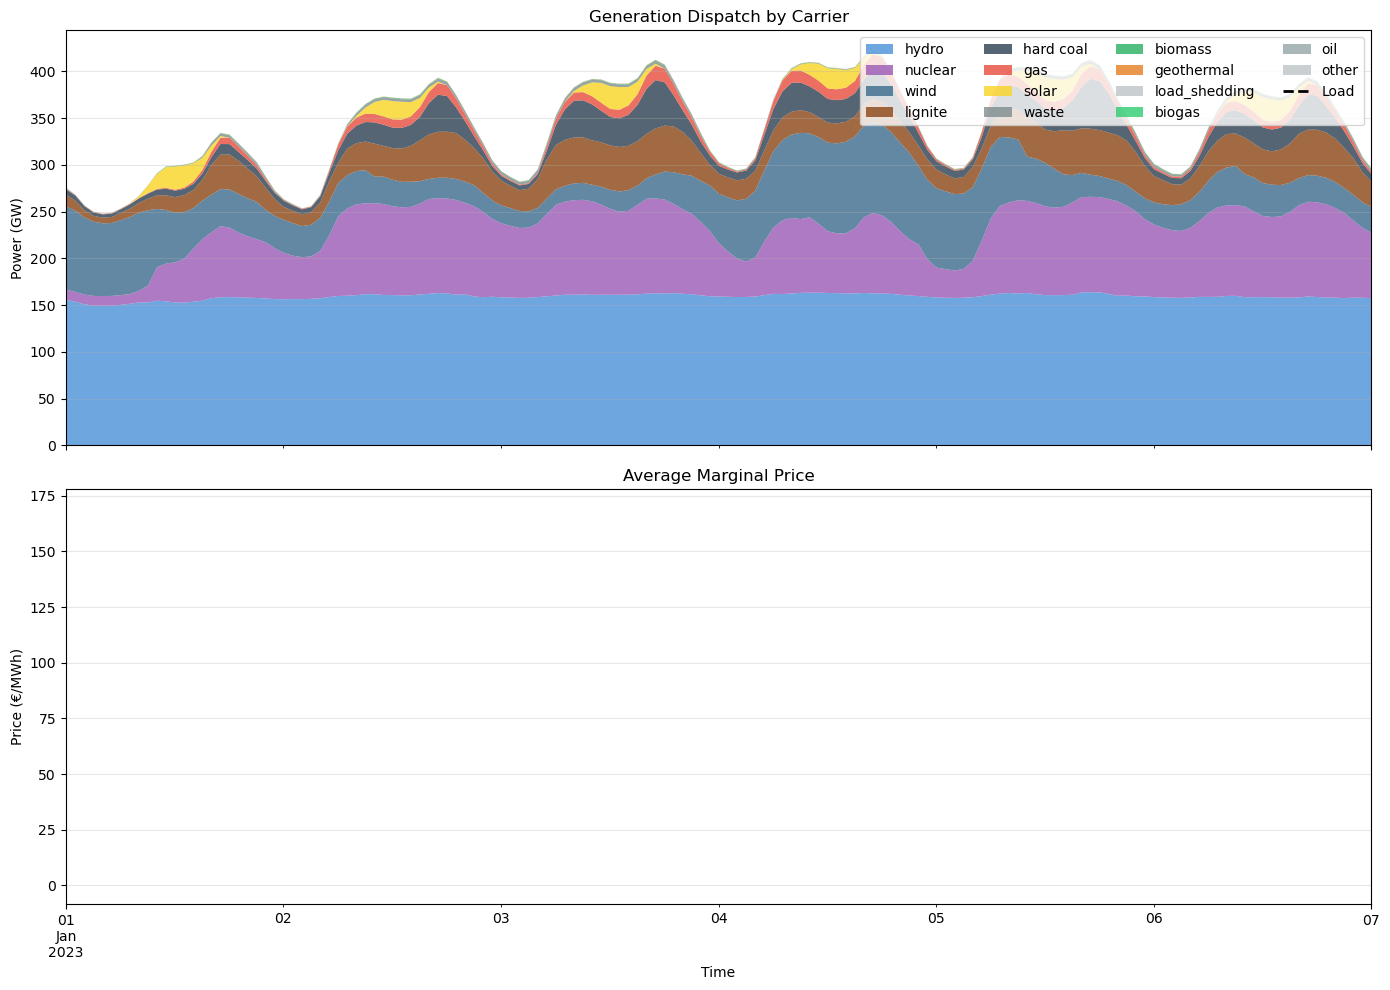

In [37]:
# =============================================================================
# PLOT DISPATCH STACK
# =============================================================================

# Color scheme (following PyPSA-EUR convention)
CARRIER_COLORS = {
    'wind': '#3B6B8C',
    'solar': '#F9D423',
    'hydro': '#4A90D9',
    'gas': '#E74C3C',
    'hard coal': '#2C3E50',
    'lignite': '#8B4513',
    'nuclear': '#9B59B6',
    'oil': '#95A5A6',
    'biomass': '#27AE60',
    'biogas': '#2ECC71',
    'waste': '#7F8C8D',
    'geothermal': '#E67E22',
    'other': '#BDC3C7',
}

if len(n_dispatch.generators_t.p.columns) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Generation stack
    ax1 = axes[0]
    gen_by_carrier = n_dispatch.generators_t.p.groupby(
        n_dispatch.generators.carrier, axis=1
    ).sum() / 1000  # GW
    
    # Sort by average generation
    gen_order = gen_by_carrier.mean().sort_values(ascending=False).index
    colors = [CARRIER_COLORS.get(c, '#BDC3C7') for c in gen_order]
    
    gen_by_carrier[gen_order].plot.area(
        ax=ax1, color=colors, alpha=0.8, linewidth=0
    )
    
    # Add load line
    total_load = n_dispatch.loads_t.p.sum(axis=1) / 1000
    ax1.plot(total_load.index, total_load.values, 'k--', linewidth=2, label='Load')
    
    ax1.set_ylabel('Power (GW)')
    ax1.set_title('Generation Dispatch by Carrier')
    ax1.legend(loc='upper right', ncol=4)
    ax1.set_ylim(0, None)
    ax1.grid(True, alpha=0.3)
    
    # Marginal prices
    ax2 = axes[1]
    if len(n_dispatch.buses_t.marginal_price.columns) > 0:
        avg_price = n_dispatch.buses_t.marginal_price.mean(axis=1)
        ax2.plot(avg_price.index, avg_price.values, 'b-', linewidth=1)
        ax2.fill_between(avg_price.index, 0, avg_price.values, alpha=0.3)
        ax2.set_ylabel('Price (€/MWh)')
        ax2.set_title('Average Marginal Price')
        ax2.grid(True, alpha=0.3)
    
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
else:
    print("No dispatch results available")

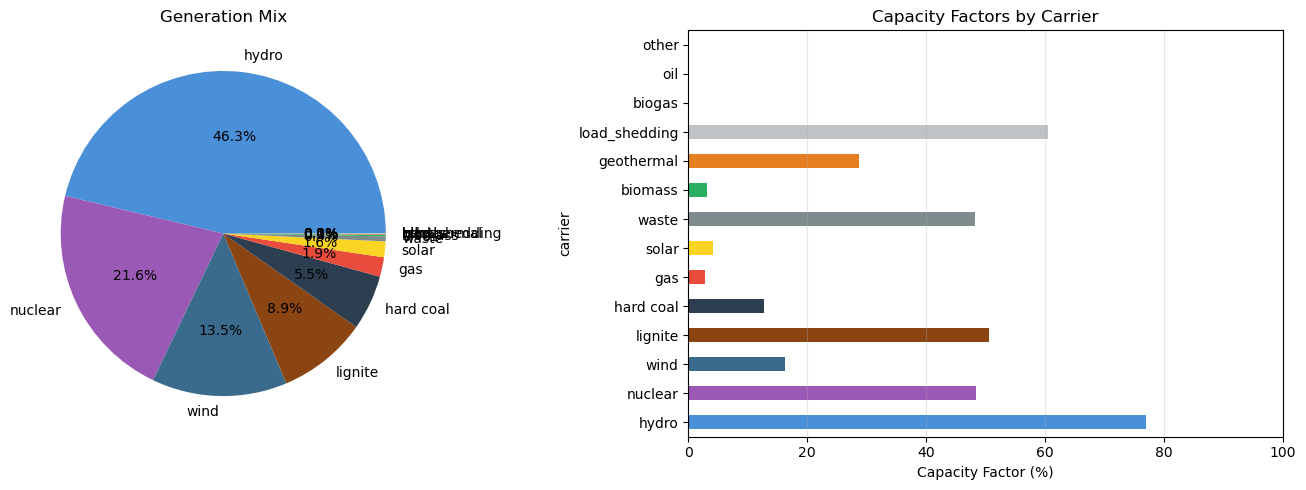

In [38]:
# =============================================================================
# PLOT GENERATION MIX
# =============================================================================

if len(n_dispatch.generators_t.p.columns) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Pie chart of total generation
    ax1 = axes[0]
    gen_total = n_dispatch.generators_t.p.groupby(
        n_dispatch.generators.carrier, axis=1
    ).sum().sum()
    gen_total = gen_total[gen_total > 0].sort_values(ascending=False)
    
    colors = [CARRIER_COLORS.get(c, '#BDC3C7') for c in gen_total.index]
    ax1.pie(gen_total, labels=gen_total.index, colors=colors, autopct='%1.1f%%')
    ax1.set_title('Generation Mix')
    
    # Capacity factor by carrier
    ax2 = axes[1]
    cf_by_carrier = []
    for carrier in gen_total.index:
        carrier_gens = n_dispatch.generators[n_dispatch.generators.carrier == carrier].index
        if len(carrier_gens) > 0:
            generation = n_dispatch.generators_t.p[carrier_gens].sum().sum()
            capacity = n_dispatch.generators.loc[carrier_gens, 'p_nom'].sum()
            cf = generation / (capacity * len(n_dispatch.snapshots)) * 100
            cf_by_carrier.append({'carrier': carrier, 'cf': cf})
    
    cf_df = pd.DataFrame(cf_by_carrier).set_index('carrier')
    colors = [CARRIER_COLORS.get(c, '#BDC3C7') for c in cf_df.index]
    cf_df['cf'].plot.barh(ax=ax2, color=colors)
    ax2.set_xlabel('Capacity Factor (%)')
    ax2.set_title('Capacity Factors by Carrier')
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

## 4. Capacity Expansion Optimization

Now we allow investments in new generation and transmission capacity.

In [39]:
# =============================================================================
# CONFIGURE CAPACITY EXPANSION
# =============================================================================

# Make a copy for expansion planning
n_expand = n.copy()

# Capital costs for new capacity (€/MW/year, following PyPSA-EUR)
CAPITAL_COSTS = {
    'wind': 85000,       # Onshore wind
    'solar': 40000,      # Utility-scale solar PV
    'gas': 45000,        # CCGT
    'battery': 150000,   # Li-ion battery
}

# Maximum expansion potential (MW per bus)
MAX_EXPANSION = {
    'wind': 10000,   # 10 GW per bus
    'solar': 10000,  # 10 GW per bus
    'gas': 5000,     # 5 GW per bus
}

# Set extendable carriers
EXTENDABLE_CARRIERS = ['wind', 'solar', 'gas']

# Make selected carriers extendable
for carrier in EXTENDABLE_CARRIERS:
    mask = n_expand.generators.carrier == carrier
    n_expand.generators.loc[mask, 'p_nom_extendable'] = True
    n_expand.generators.loc[mask, 'capital_cost'] = CAPITAL_COSTS.get(carrier, 0)
    n_expand.generators.loc[mask, 'p_nom_max'] = (
        n_expand.generators.loc[mask, 'p_nom'] + MAX_EXPANSION.get(carrier, 10000)
    )

# Also allow line expansion
n_expand.lines['s_nom_extendable'] = True
n_expand.lines['s_nom_max'] = n_expand.lines['s_nom'] * 3  # Max 3x current capacity
n_expand.lines['capital_cost'] = 400  # €/MW/km (simplified)

print("Capacity expansion configuration:")
print(f"  Extendable carriers: {EXTENDABLE_CARRIERS}")
print(f"  Extendable generators: {n_expand.generators['p_nom_extendable'].sum()}")
print(f"  Extendable lines: {n_expand.lines['s_nom_extendable'].sum()}")

Capacity expansion configuration:
  Extendable carriers: ['wind', 'solar', 'gas']
  Extendable generators: 2009
  Extendable lines: 237


In [40]:
# =============================================================================
# RUN CAPACITY EXPANSION OPTIMIZATION
# =============================================================================

print("\n" + "="*60)
print("SOLVING CAPACITY EXPANSION")
print("="*60)
print(f"\nUsing solver: {SOLVER_NAME}")

# More aggressive solver settings for expansion problem
expand_solver_options = SOLVER_OPTIONS.copy()
if SOLVER_NAME == 'gurobi':
    expand_solver_options['MIPGap'] = 0.05  # 5% gap for faster solve

# Solve
status, termination_condition = n_expand.optimize(
    solver_name=SOLVER_NAME,
    solver_options=expand_solver_options,
)

print(f"\n{'='*60}")
print(f"Status: {status}")
print(f"Termination: {termination_condition}")
print(f"Objective value: {n_expand.objective / 1e6:.2f} M€")


SOLVING CAPACITY EXPANSION

Using solver: gurobi


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - MIPGap: 0.05
 - TimeLimit: 7200
 - Threads: 10
 - Method: 2
 - Crossover: 0
 - BarHomogeneous: 1
 - OutputFlag: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 37.09it/s]
INFO:linopy.io: Writing time: 2.11s


Set parameter Username
Set parameter LicenseID to value 2755728
Academic license - for non-commercial use only - expires 2026-12-16
Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-1eni0ts9.lp
Reading time = 2.14 seconds
obj: 2491532 rows, 1223582 columns, 4133873 nonzeros
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 7200
Set parameter Threads to value 10
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarHomogeneous to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  7200
MIPGap  0.05
Method  2
BarHomogeneous  1
Crossover  0
Threads  10

Optimize a model with 2491532 rows, 1223582 columns and 4133873 nonzeros (Min)
Model fingerprint: 0x17cde50f
Model has 544112 

Status: ok
Termination condition: suboptimal
Solution: 1223582 primals, 2491532 duals
Objective: -4.00e+10
Solver model: available
Solver message: 13

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.



Status: ok
Termination: suboptimal
Objective value: -39988.80 M€


In [41]:
# =============================================================================
# ANALYZE EXPANSION RESULTS
# =============================================================================

def analyze_expansion_results(n):
    """Analyze capacity expansion results."""
    print("\n" + "="*60)
    print("CAPACITY EXPANSION RESULTS")
    print("="*60)
    
    # New generator capacity by carrier
    new_gen_cap = n.generators.groupby('carrier').apply(
        lambda g: (g['p_nom_opt'] - g['p_nom']).sum() / 1000  # GW
    )
    new_gen_cap = new_gen_cap[new_gen_cap.abs() > 0.01]
    
    print(f"\nNew generation capacity (GW):")
    for carrier, cap in new_gen_cap.sort_values(ascending=False).items():
        print(f"  {carrier:15} {cap:+8.2f}")
    print(f"  {'TOTAL':15} {new_gen_cap.sum():+8.2f}")
    
    # New line capacity
    if 's_nom_opt' in n.lines.columns:
        new_line_cap = (n.lines['s_nom_opt'] - n.lines['s_nom']).sum() / 1000  # GW
        print(f"\nNew transmission capacity: {new_line_cap:+.2f} GW")
    
    # Investment costs breakdown
    print(f"\nInvestment costs:")
    
    gen_investment = n.generators.groupby('carrier').apply(
        lambda g: ((g['p_nom_opt'] - g['p_nom']).clip(lower=0) * g['capital_cost']).sum() / 1e6
    )
    gen_investment = gen_investment[gen_investment > 0.01]
    
    for carrier, cost in gen_investment.sort_values(ascending=False).items():
        print(f"  {carrier:15} {cost:8.2f} M€")
    
    total_gen_investment = gen_investment.sum()
    print(f"  {'Total gen':15} {total_gen_investment:8.2f} M€")

analyze_expansion_results(n_expand)


CAPACITY EXPANSION RESULTS

New generation capacity (GW):
  solar            -131.73
  gas              -240.02
  wind             -286.63
  TOTAL            -658.38

New transmission capacity: -840.99 GW

Investment costs:
  gas                10.55 M€
  solar               7.71 M€
  Total gen          18.26 M€


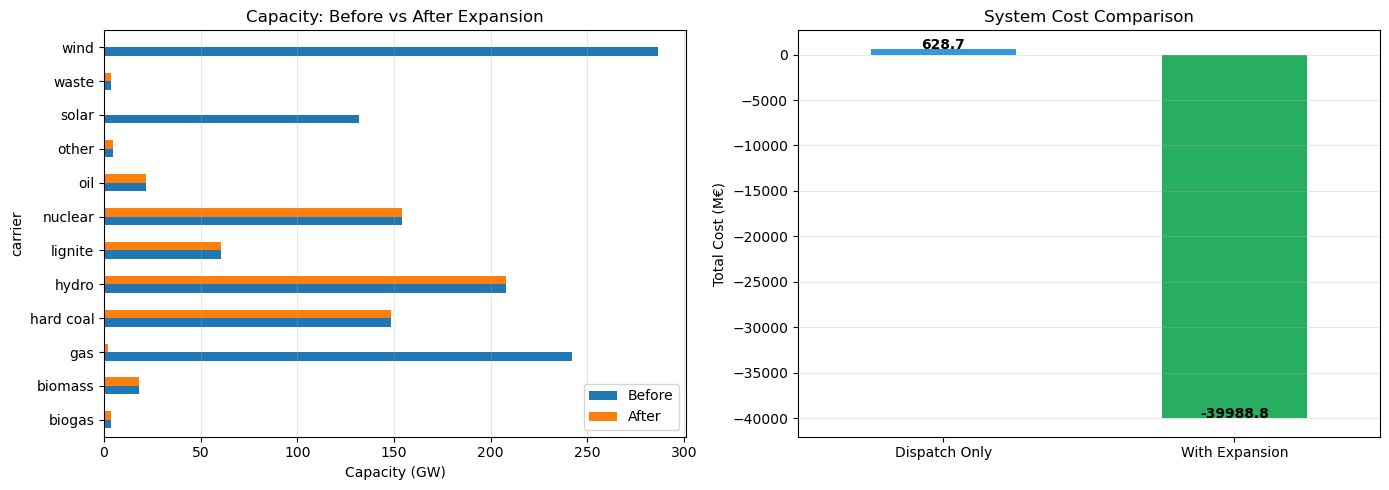

In [42]:
# =============================================================================
# COMPARE DISPATCH VS EXPANSION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Capacity comparison
ax1 = axes[0]

cap_dispatch = n_dispatch.generators.groupby('carrier')['p_nom'].sum() / 1000
cap_expand = n_expand.generators.groupby('carrier')['p_nom_opt'].sum() / 1000

cap_compare = pd.DataFrame({
    'Before': cap_dispatch,
    'After': cap_expand
}).fillna(0)

cap_compare = cap_compare[cap_compare.max(axis=1) > 1]  # Filter small
cap_compare.plot.barh(ax=ax1)
ax1.set_xlabel('Capacity (GW)')
ax1.set_title('Capacity: Before vs After Expansion')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# Cost comparison
ax2 = axes[1]

costs = pd.Series({
    'Dispatch Only': n_dispatch.objective / 1e6,
    'With Expansion': n_expand.objective / 1e6
})

bars = costs.plot.bar(ax=ax2, color=['#3498db', '#27ae60'])
ax2.set_ylabel('Total Cost (M€)')
ax2.set_title('System Cost Comparison')
ax2.tick_params(axis='x', rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(costs.values):
    ax2.text(i, v + costs.max()*0.02, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Advanced: Adding Constraints

Following PyPSA-EUR, we can add custom constraints like CO₂ limits.

In [43]:
# =============================================================================
# ADD CO2 CONSTRAINT
# =============================================================================

# CO2 emission factors (t CO2 / MWh)
CO2_FACTORS = {
    'gas': 0.41,
    'hard coal': 0.90,
    'lignite': 1.10,
    'oil': 0.70,
    'biomass': 0.0,   # Considered carbon-neutral
    'biogas': 0.0,
    'wind': 0.0,
    'solar': 0.0,
    'nuclear': 0.0,
    'hydro': 0.0,
}

# Calculate emissions from dispatch optimization
if len(n_dispatch.generators_t.p.columns) > 0:
    emissions_by_carrier = {}
    total_emissions = 0
    
    for carrier, factor in CO2_FACTORS.items():
        carrier_gens = n_dispatch.generators[
            n_dispatch.generators.carrier == carrier
        ].index
        
        if len(carrier_gens) > 0 and any(g in n_dispatch.generators_t.p.columns for g in carrier_gens):
            valid_gens = [g for g in carrier_gens if g in n_dispatch.generators_t.p.columns]
            generation = n_dispatch.generators_t.p[valid_gens].sum().sum()  # MWh
            emissions = generation * factor / 1e6  # Mt CO2
            emissions_by_carrier[carrier] = emissions
            total_emissions += emissions
    
    print("\nCO2 Emissions from Dispatch Optimization:")
    print("="*40)
    for carrier, emissions in sorted(emissions_by_carrier.items(), key=lambda x: -x[1]):
        if emissions > 0.001:
            print(f"  {carrier:15} {emissions:.3f} Mt CO2")
    print(f"  {'TOTAL':15} {total_emissions:.3f} Mt CO2")


CO2 Emissions from Dispatch Optimization:
  lignite         4.904 Mt CO2
  hard coal       2.465 Mt CO2
  gas             0.398 Mt CO2
  TOTAL           7.767 Mt CO2


In [44]:
# =============================================================================
# SOLVE WITH CO2 LIMIT (USING GLOBAL CONSTRAINT)
# =============================================================================

# Create network with CO2 limit
n_co2 = n.copy()

# Make renewables extendable
for carrier in ['wind', 'solar']:
    mask = n_co2.generators.carrier == carrier
    n_co2.generators.loc[mask, 'p_nom_extendable'] = True
    n_co2.generators.loc[mask, 'capital_cost'] = CAPITAL_COSTS.get(carrier, 0)
    n_co2.generators.loc[mask, 'p_nom_max'] = (
        n_co2.generators.loc[mask, 'p_nom'] + 50000  # 50 GW additional
    )

# Add CO2 carriers attribute to generators
for gen_idx, gen in n_co2.generators.iterrows():
    carrier = gen['carrier']
    co2_factor = CO2_FACTORS.get(carrier, 0)
    # PyPSA uses efficiency to calculate emissions
    # emissions = generation / efficiency * co2_factor
    # For simplicity, we encode directly

# Add carriers with CO2 emissions
carriers_df = pd.DataFrame({
    'co2_emissions': [CO2_FACTORS.get(c, 0) for c in n_co2.generators.carrier.unique()]
}, index=n_co2.generators.carrier.unique())

# Add to network carriers
for carrier in carriers_df.index:
    if carrier not in n_co2.carriers.index:
        n_co2.add('Carrier', carrier, co2_emissions=carriers_df.loc[carrier, 'co2_emissions'])
    else:
        n_co2.carriers.loc[carrier, 'co2_emissions'] = carriers_df.loc[carrier, 'co2_emissions']

# Set CO2 limit (50% reduction from baseline)
CO2_LIMIT = total_emissions * 0.5 * 1e6  # Convert back to tonnes

# Add global CO2 constraint
n_co2.add(
    'GlobalConstraint',
    'co2_limit',
    type='primary_energy',
    carrier_attribute='co2_emissions',
    sense='<=',
    constant=CO2_LIMIT
)

print(f"\nSolving with CO2 limit: {CO2_LIMIT/1e6:.3f} Mt (50% reduction)")

# Solve
status, termination_condition = n_co2.optimize(
    solver_name=SOLVER_NAME,
    solver_options=expand_solver_options,
)

print(f"\nStatus: {status}")
print(f"Objective: {n_co2.objective / 1e6:.2f} M€")


Solving with CO2 limit: 3.884 Mt (50% reduction)


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - MIPGap: 0.05
 - TimeLimit: 7200
 - Threads: 10
 - Method: 2
 - Crossover: 0
 - BarHomogeneous: 1
 - OutputFlag: 1
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s]
INFO:linopy.io: Writing time: 2.19s


Set parameter Username
Set parameter LicenseID to value 2755728
Academic license - for non-commercial use only - expires 2026-12-16
Read LP format model from file /private/var/folders/y8/4_9g68pj7k136q2yypgp5ysc0000gn/T/linopy-problem-fqqtbb3w.lp
Reading time = 2.32 seconds
obj: 2487769 rows, 1221700 columns, 4191734 nonzeros
Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 7200
Set parameter Threads to value 10
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter BarHomogeneous to value 1
Set parameter OutputFlag to value 1
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.1.0 25B78)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  7200
MIPGap  0.05
Method  2
BarHomogeneous  1
Crossover  0
Threads  10

Optimize a model with 2487769 rows, 1221700 columns and 4191734 nonzeros (Min)
Model fingerprint: 0x7cc72b9e
Model has 542230 

Status: ok
Termination condition: suboptimal
Solution: 1221700 primals, 2487769 duals
Objective: -1.68e+10
Solver model: available
Solver message: 13

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, Kirchhoff-Voltage-Law were not assigned to the network.



Status: ok
Objective: -16786.62 M€


## 6. Save Optimized Network

Export the solved network for further analysis.

In [45]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

results_dir = results_path / "optimization"
results_dir.mkdir(parents=True, exist_ok=True)

# Save optimized networks
dispatch_file = results_dir / "network_dispatch_optimized.nc"
expand_file = results_dir / "network_expansion_optimized.nc"

n_dispatch.export_to_netcdf(dispatch_file)
n_expand.export_to_netcdf(expand_file)

print(f"Saved dispatch results to: {dispatch_file}")
print(f"Saved expansion results to: {expand_file}")

# Export summary statistics
summary = {
    'dispatch_cost_meur': n_dispatch.objective / 1e6,
    'expansion_cost_meur': n_expand.objective / 1e6,
    'dispatch_gen_twh': n_dispatch.generators_t.p.sum().sum() / 1e6,
    'n_buses': len(n.buses),
    'n_generators': len(n.generators),
    'n_snapshots': len(n.snapshots),
}

summary_df = pd.Series(summary)
summary_df.to_csv(results_dir / "optimization_summary.csv")

print("\nSummary:")
print(summary_df)

INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/optimization/network_dispatch_optimized.nc contains: loads, generators, carriers, sub_networks, buses, links, lines
INFO:pypsa.network.io:Exported network 'Unnamed Network' saved to '/Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/optimization/network_expansion_optimized.nc contains: loads, generators, carriers, sub_networks, buses, links, lines


Saved dispatch results to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/optimization/network_dispatch_optimized.nc
Saved expansion results to: /Users/jedrek/Documents/Studium Volkswirschaftslehre/3. Semester/European Energy Policy/HA/PyPSA---Simplified-European-Model/PyPSA---Simplified-European-Model/results/optimization/network_expansion_optimized.nc

Summary:
dispatch_cost_meur       628.662783
expansion_cost_meur   -39988.800067
dispatch_gen_twh          50.061579
n_buses                  200.000000
n_generators            8158.000000
n_snapshots              145.000000
dtype: float64


## Summary

This notebook demonstrated:

1. **Dispatch optimization** - Economic dispatch with fixed capacities
2. **Capacity expansion** - Joint optimization of dispatch and investments
3. **CO₂ constraints** - Adding emission limits using PyPSA's GlobalConstraint
4. **Result analysis** - Generation mix, costs, capacity factors, congestion

### Key PyPSA-EUR Methodology Elements Used:

- **Gurobi solver** with appropriate options (barrier method, MIP gap)
- **Carrier-based modeling** for generation technologies
- **Capital costs** for extendable components
- **CO₂ emission factors** by carrier
- **Global constraints** for policy limits

### Next Steps:

- Add storage (batteries, pumped hydro)
- Multi-period optimization with rolling horizon
- Sector coupling (heating, transport)
- Sensitivity analysis with scenarios

---

*Following PyPSA-EUR methodology for European energy system modeling.*